### Model

In [72]:
import pandas as pd
import optuna
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, FunctionTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

file_path = "LoanData.csv"
file_path_features = "features.csv" 

def load_data(file_path):
    """
    Load the loan data from a CSV file into a pandas DataFrame.

    Parameters:
    file_path (str): The path to the CSV file.

    Returns:
    pd.DataFrame: The loan data.
    """
    return pd.read_csv(file_path)

def load_features(file_path):
    """
    Load the features from a CSV file.

    Parameters:
    file_path (str): The path to the CSV file.

    Returns:
    pd.Series: The features.
    """
    return pd.read_csv(file_path, header=None).squeeze("columns")

# Read the loan data into a DataFrame
loan_data = load_data(file_path)

# Read the features from the CSV file
features = load_features(file_path_features)

# Filter the loan data based on the selected features
filtered_loan_data1 = loan_data[features]
filtered_loan_data = filtered_loan_data1.copy()

/var/folders/tn/4ww1ljcj1tg4z0j08hx0ntz80000gn/T/ipykernel_47817/3121919094.py:33: DtypeWarning: Columns (12,34,38,67,80,82,83,89,90) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(file_path)


In [73]:
# Convert 'LoanDate' and 'DefaultDate' columns to datetime format
filtered_loan_data['LoanDate'] = pd.to_datetime(filtered_loan_data['LoanDate'])
filtered_loan_data['DefaultDate'] = pd.to_datetime(filtered_loan_data['DefaultDate'])

# Calculate the time difference in days between 'DefaultDate' and 'LoanDate'
filtered_loan_data['TimeDifference'] = (filtered_loan_data['DefaultDate'] - filtered_loan_data['LoanDate']).dt.days

# Create a new binary feature indicating if the time difference is less than 12 months
filtered_loan_data['DefaultWithin12Months'] = (filtered_loan_data['TimeDifference'] < 365) & ~filtered_loan_data['DefaultDate'].isnull()

# Drop the intermediate 'TimeDifference' column if not needed for further analysis
filtered_loan_data.drop(['TimeDifference', 'LoanApplicationStartedDate', 'DefaultDate'], axis=1, inplace=True)

In [74]:
# Calculate the number of NaN values in each column
nan_counts = filtered_loan_data.replace('nan', float('nan')).isna().sum()

# Select columns that have less than or equal to 50% NaN values
columns_without_nan = nan_counts[nan_counts / len(filtered_loan_data) <= 0.5].index.tolist()

# Filter the loan data by keeping only the selected columns and dropping the 'LoanDate' column
filtered_loan_data_filtered = filtered_loan_data[columns_without_nan].drop('LoanDate', axis=1)

# Drop columns with more than 50% values as -1
filtered_loan_data_filtered = filtered_loan_data_filtered.loc[:, (filtered_loan_data_filtered != -1).mean() >= 0.1]

# Drop columns with more than 50% values as 0
filtered_loan_data_filtered = filtered_loan_data_filtered.loc[:, (filtered_loan_data_filtered != 0).mean() >= 0.1]

In [75]:
# Select the numerical features by excluding the 'object' dtype
numerical_features = selector(dtype_exclude=object)(filtered_loan_data_filtered.drop('DefaultWithin12Months', axis=1))

# Define the categorical features
categorical_features = ['NewCreditCustomer', 'ApplicationSignedWeekday', 'LanguageCode','EmploymentDurationCurrentEmployer', 'HomeOwnershipType', 'Education', 'Country']

# Convert the selected categorical features to 'object' dtype
filtered_loan_data_filtered[categorical_features] = filtered_loan_data_filtered[categorical_features].astype('object')

# Define the numeric transformer pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Define the categorical transformer pipeline
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Define the preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

# Separate the features and target variable
X = filtered_loan_data_filtered.drop(['DefaultWithin12Months'], axis=1)
y = filtered_loan_data_filtered['DefaultWithin12Months']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

# Apply oversampling to the training data
oversampler = RandomOverSampler(random_state=0)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

# Preprocess the resampled training data
X_train_resampled = preprocessor.fit_transform(X_train_resampled)

# Initialize the XGBoost classifier model
model = XGBClassifier(random_state=0)

# Fit the model to the resampled training data
model.fit(X_train_resampled, y_train_resampled)

# Preprocess the testing data
X_test = preprocessor.transform(X_test)

# Perform hyperparameter tuning using GridSearchCV
param_grid = {
    'learning_rate': [0.1, 0.01],
    'max_depth': [3, 5]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='roc_auc', cv=5)
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Update the model with the best parameters
model.set_params(**best_params)

# Fit the model to the resampled training data with the updated parameters
model.fit(X_train_resampled, y_train_resampled)

# Predict probabilities for the testing data
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)

# Calculate the AUC
auc = roc_auc_score(y_test, y_pred_proba)
print("AUC:", auc)

# Calculate the classification report
report = classification_report(y_test, y_pred)
print(report)

AUC: 0.7840737423309253
              precision    recall  f1-score   support

       False       0.91      0.75      0.83     28409
        True       0.37      0.66      0.47      6079

    accuracy                           0.74     34488
   macro avg       0.64      0.71      0.65     34488
weighted avg       0.82      0.74      0.76     34488



### Plots for poster

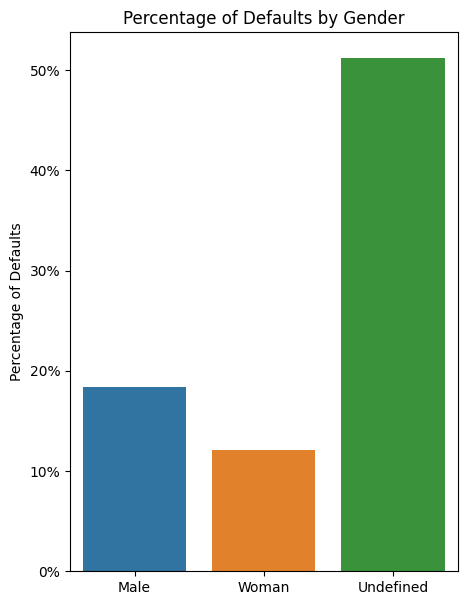

In [76]:
plt.figure(figsize=(5, 7))
# Group the data by gender and count the number of default loans
default_counts = filtered_loan_data_filtered.groupby('Gender')['DefaultWithin12Months'].sum()
# Calculate the total number of loans by gender
total_counts = filtered_loan_data_filtered['Gender'].value_counts()

# Calculate the percentage of defaults by gender
default_percentages = (default_counts / total_counts) * 100

# Plot the percentage of defaults by gender
sns.barplot(x=default_percentages.index, y=default_percentages.values)
plt.xlabel('')
plt.ylabel('Percentage of Defaults')
plt.title('Percentage of Defaults by Gender')

# Format the y-axis as percentages
fmt = '%.0f%%'
yticks = mtick.FormatStrFormatter(fmt)
plt.gca().yaxis.set_major_formatter(yticks)

# Customize the x-tick labels
plt.gca().set_xticklabels(['Male', 'Woman', 'Undefined'])


plt.show()

In [77]:
# Calculate the number of NaN values in each column
nan_counts = filtered_loan_data1.replace('nan', float('nan')).isna().sum()

# Select columns with NaN values less than or equal to 50% of the total number of rows
columns_without_nan = nan_counts[nan_counts / len(filtered_loan_data1) <= 0.5].index.tolist()

# Filter the loan data by selecting only the columns without excessive NaN values
filtered_loan_data_filtered1 = filtered_loan_data1[columns_without_nan]

# Filter the data further by removing columns with more than 90% values as -1
data1 = filtered_loan_data_filtered1[filtered_loan_data_filtered1.loc[:, (filtered_loan_data_filtered1 != -1).mean() >= 0.1].columns]

# Filter the data further by removing columns with more than 90% values as 0
data2 = data1[data1.loc[:, (data1 != 0).mean() >= 0.1].columns]


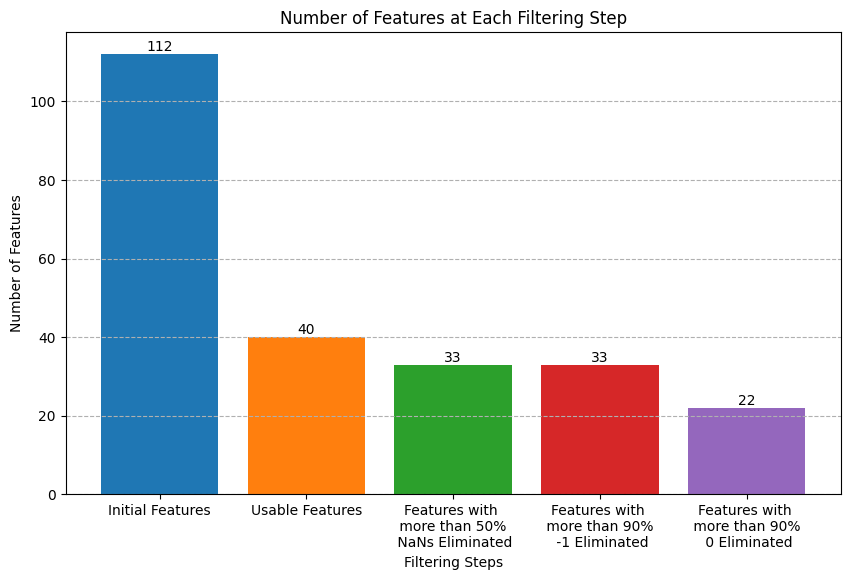

In [78]:
# Define the filtering steps
filtering_steps = ['Initial Features', 
                   'Usable Features',
                   'Features with \n more than 50% \n NaNs Eliminated', 
                   'Features with \n more than 90% \n -1 Eliminated', 
                   'Features with \n more than 90% \n 0 Eliminated']
# Define the number of features at each filtering step
feature_counts = [len(loan_data.columns), 
                  len(features),
                  len(columns_without_nan), 
                  len(data1.columns), 
                  len(data2.columns)]

# Set the figure size
plt.figure(figsize=(10, 6))

# Create the barplot with custom colors
plt.bar(filtering_steps, feature_counts, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])

# Set the x-axis label and rotate the x-axis labels for better visibility
plt.xlabel('Filtering Steps')
plt.xticks(rotation=0, ha='center')

# Set the y-axis label
plt.ylabel('Number of Features')

# Set the title
plt.title('Number of Features at Each Filtering Step')

# Add grid lines
plt.grid(axis='y', linestyle='--')

# Add data labels to the bars
for i, count in enumerate(feature_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')
plt.show()


/var/folders/tn/4ww1ljcj1tg4z0j08hx0ntz80000gn/T/ipykernel_47817/343894961.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_loan_data1['LoanDate'] = pd.to_datetime(filtered_loan_data1['LoanDate'])
/var/folders/tn/4ww1ljcj1tg4z0j08hx0ntz80000gn/T/ipykernel_47817/343894961.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_loan_data1['DefaultDate'] = pd.to_datetime(filtered_loan_data1['DefaultDate'])
/var/folders/tn/4ww1ljcj1tg4z0j08hx0ntz80000gn/T/ipykernel_47817/343894961.py:4: Setting

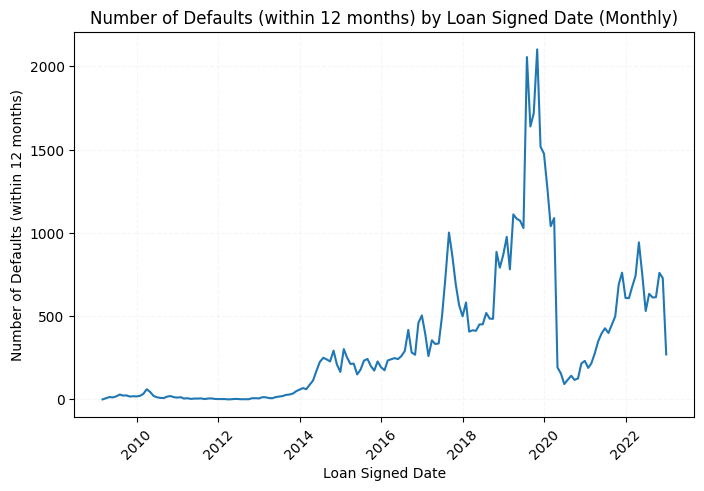

In [79]:
from datetime import datetime, timedelta
filtered_loan_data1['LoanDate'] = pd.to_datetime(filtered_loan_data1['LoanDate'])
filtered_loan_data1['DefaultDate'] = pd.to_datetime(filtered_loan_data1['DefaultDate'])
filtered_loan_data1['TimeDifference'] = (filtered_loan_data1['DefaultDate'] - filtered_loan_data1['LoanDate']).dt.days

# Filter out loans within the last 12 months as of today
today = datetime.now().date()
filtered_loan_data1 = filtered_loan_data1[filtered_loan_data1['LoanDate'] < pd.to_datetime(today - timedelta(days=365))]

# Create a new binary feature indicating if the time difference is less than 12 months
filtered_loan_data1['DefaultWithin12Months'] = (filtered_loan_data1['TimeDifference'] < 365) & ~filtered_loan_data1['DefaultDate'].isnull()

# Group the data by the signed date and count the number of defaults
defaults_by_date = filtered_loan_data1.groupby(pd.Grouper(key='LoanDate', freq='M'))['DefaultWithin12Months'].sum()
plt.figure(figsize=(8, 5))

# Create a line plot
plt.plot(defaults_by_date.index, defaults_by_date.values)
plt.xlabel('Loan Signed Date')
plt.ylabel('Number of Defaults (within 12 months)')
plt.title('Number of Defaults (within 12 months) by Loan Signed Date (Monthly)')

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.1)

# Display the plot
plt.show()


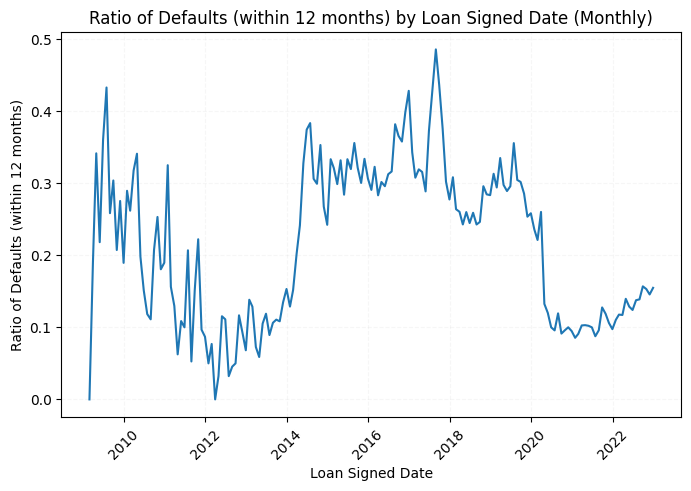

In [80]:
# Group the data by the signed date and count the number of defaults
defaults_by_date = filtered_loan_data1.groupby(pd.Grouper(key='LoanDate', freq='M'))['DefaultWithin12Months'].mean()
plt.figure(figsize=(8, 5))

# Create a line plot
plt.plot(defaults_by_date.index, defaults_by_date.values)
plt.xlabel('Loan Signed Date')
plt.ylabel('Ratio of Defaults (within 12 months)')
plt.title('Ratio of Defaults (within 12 months) by Loan Signed Date (Monthly)')

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.1)

# Display the plot
plt.show()


### EDA report

In [81]:
from ydata_profiling import ProfileReport
ydata = filtered_loan_data_filtered.copy(deep=True)
profile = ProfileReport(ydata, title="Profiling Report")
profile.to_file("your_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/ydata_profiling/model/pandas/discretize_pandas.py:52: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  discretized_df.loc[:, column] = self._discretize_column(


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### Optuna hyperparameter optimization


In [87]:
def objective(trial):
    # Define the hyperparameters to tune
    params = {
        'learning_rate': trial.suggest_categorical('learning_rate', [0.1, 0.2, 0.3, 0.5, 0.8]),
        'max_depth': trial.suggest_int('max_depth', 5, 15)
    }

    # Initialize the XGBoost classifier model with the current hyperparameters
    model = XGBClassifier(random_state=0, **params)

    # Fit the model to the resampled training data
    model.fit(X_train_resampled, y_train_resampled)

    # Predict probabilities for the testing data
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calculate the AUC
    auc = roc_auc_score(y_test, y_pred_proba)

    return auc

# Perform hyperparameter tuning using Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=15)

# Get the best hyperparameters and best score
best_params = study.best_params
best_score = study.best_value

# Update the model with the best hyperparameters
model.set_params(**best_params)

# Fit the model to the resampled training data with the updated hyperparameters
model.fit(X_train_resampled, y_train_resampled)

# Predict probabilities for the testing data
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)

# Calculate the AUC
auc = roc_auc_score(y_test, y_pred_proba)
print("AUC:", auc)

# Calculate the classification report
report = classification_report(y_test, y_pred)
print(report)

[I 2023-12-10 21:09:11,995] A new study created in memory with name: no-name-be37dc76-d8b7-4868-aadd-46604fbc7d73


[I 2023-12-10 21:09:41,485] Trial 0 finished with value: 0.7826392117986608 and parameters: {'learning_rate': 0.5, 'max_depth': 8}. Best is trial 0 with value: 0.7826392117986608.
[I 2023-12-10 21:10:10,133] Trial 1 finished with value: 0.7734432040855338 and parameters: {'learning_rate': 0.8, 'max_depth': 7}. Best is trial 0 with value: 0.7826392117986608.
[I 2023-12-10 21:10:26,489] Trial 2 finished with value: 0.7926190430432178 and parameters: {'learning_rate': 0.3, 'max_depth': 5}. Best is trial 2 with value: 0.7926190430432178.
[I 2023-12-10 21:10:54,168] Trial 3 finished with value: 0.7728794029722734 and parameters: {'learning_rate': 0.5, 'max_depth': 10}. Best is trial 2 with value: 0.7926190430432178.
[I 2023-12-10 21:11:13,089] Trial 4 finished with value: 0.7734432040855338 and parameters: {'learning_rate': 0.8, 'max_depth': 7}. Best is trial 2 with value: 0.7926190430432178.
[I 2023-12-10 21:11:33,582] Trial 5 finished with value: 0.7947925240565903 and parameters: {'learn

AUC: 0.7981684227357616
              precision    recall  f1-score   support

       False       0.92      0.77      0.84     28409
        True       0.39      0.67      0.49      6079

    accuracy                           0.75     34488
   macro avg       0.65      0.72      0.66     34488
weighted avg       0.82      0.75      0.78     34488



Even with optuna parameter tuning, the auc and the precision for predicting defaults is not good. This means that additional features and feature engineering is needed in order to have more relevant predictors.